# Fitting raw sunspot data

In this notebook I will take a random sample of points from the raw data, which is very noisy and will prove more challenging to model than the smoothed SVG signal.

For this I will be using the ***qusi-periodic kernel function***, given by:

$$ k_{i,j} = A^2 \exp{\left[-\frac{(x_i-x_j)^2}{2 l^2} - \sin^2{\left(\frac{\pi (x_i - x_j)}{P} \right)} \right]} + \sigma^2 \delta_{ij}$$

A list of kernel functions for PyMC3 can be found at https://docs.pymc.io/en/v3/api/gp/cov.html

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pymc3 as pm
import scipy as sp
import arviz as az
from astropy.time import Time

In [2]:
df = pd.read_csv (r'Data/Sunspots.csv') # importing raw data
xcol = 'Date'
ycol = 'Monthly Mean Total Sunspot Number'

X = (df[xcol].values)
y = df[ycol].values

In [8]:
from datetime import datetime

''' Note: JD is in days'''

time = [Time(datetime.strptime(X[i], '%Y-%m-%d')).jd
       for i in range(len(X))]

In [32]:
rng = np.random.RandomState(7) # random selection of points
training_indices = rng.choice(np.arange(y.size), size=300, replace=False)

/opt/anaconda3/lib/python3.9/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "dtf2d" yielded 244 of "dubious year (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


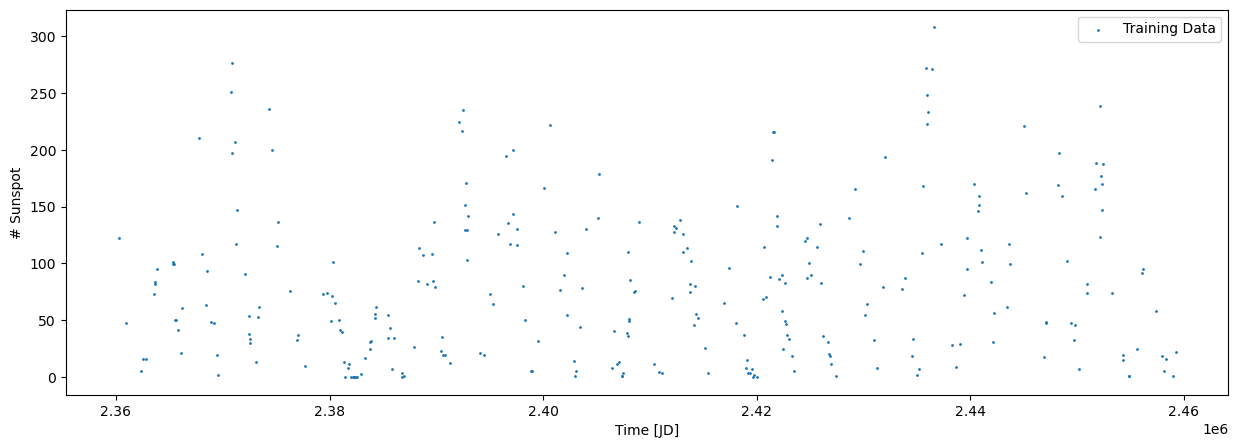

In [33]:
X_train = np.asarray([datetime.strptime(X[training_indices][i], '%Y-%m-%d') 
           for i in range(len(training_indices))]).reshape(-1,1)  # x & y values of random indicies
y_train = y[training_indices]

fig, ax = plt.subplots(1, dpi=100, figsize=[15,5])

ax.scatter(Time(X_train).jd, y_train, label='Training Data', s=1)
ax.set_xlabel('Time [JD]')
ax.set_ylabel("# Sunspot")
#ax.set_xticks
ax.legend();

PyMC3 doesn't contain the quasi-periodic kernel, but it *does* contain a **periodic kernel** as well as a **squared exponential kernel**, which we can multiply togehter to arrive at our desired kernel.

In [34]:
time_train = Time(X_train).jd # converting to Julian date

In [49]:
with pm.Model() as model:
    
    period = pm.Normal('Period', 365.25*11, 365.25*2) # converting days to years
    A = pm.Normal('A',35,5)
    length_scale1 = pm.Deterministic('Length Scale 1', 
                                    pm.Beta('ls1', 2, 2) * 365.25*10 + 5)
    length_scale2 = pm.Deterministic('Length Scale 2', 
                                    pm.Beta('ls2', 2, 2) * 365.25*1)
    sigma = pm.Deterministic('$\sigma$',
                             pm.Beta('sigma', 2, 2) * 10 + 30)
    
    cov_periodic = pm.gp.cov.Periodic(1, period=period, ls=length_scale1) # periodic kernel
    cov_SE = pm.gp.cov.ExpQuad(1, ls=length_scale2) # squared exponential kernel
    cov_qp = A**2 * cov_SE * cov_periodic  # quasi-periodic kernel
    
    mu = pm.Normal('$\mu$', 77, 5)
    const_func = pm.gp.mean.Constant(mu)
    
    gp = pm.gp.Marginal(cov_func=cov_qp, mean_func=const_func)  # implementation of the sum of a GP prior and noise

    y_ = gp.marginal_likelihood("y", X=time_train, y=y_train, noise=sigma) 

    tr = pm.sample(return_inferencedata=True) # finds local maximimum 'a posteriori point' given a model

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [$\mu$, sigma, ls2, ls1, A, Period]


/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 591 seconds.


**NOTE**: It is very difficult to gauge what the parameters *should* be, as all the values are in Julian Date rather than Gregorian. In an attempt to find the best ones I have used widely distributed priors.

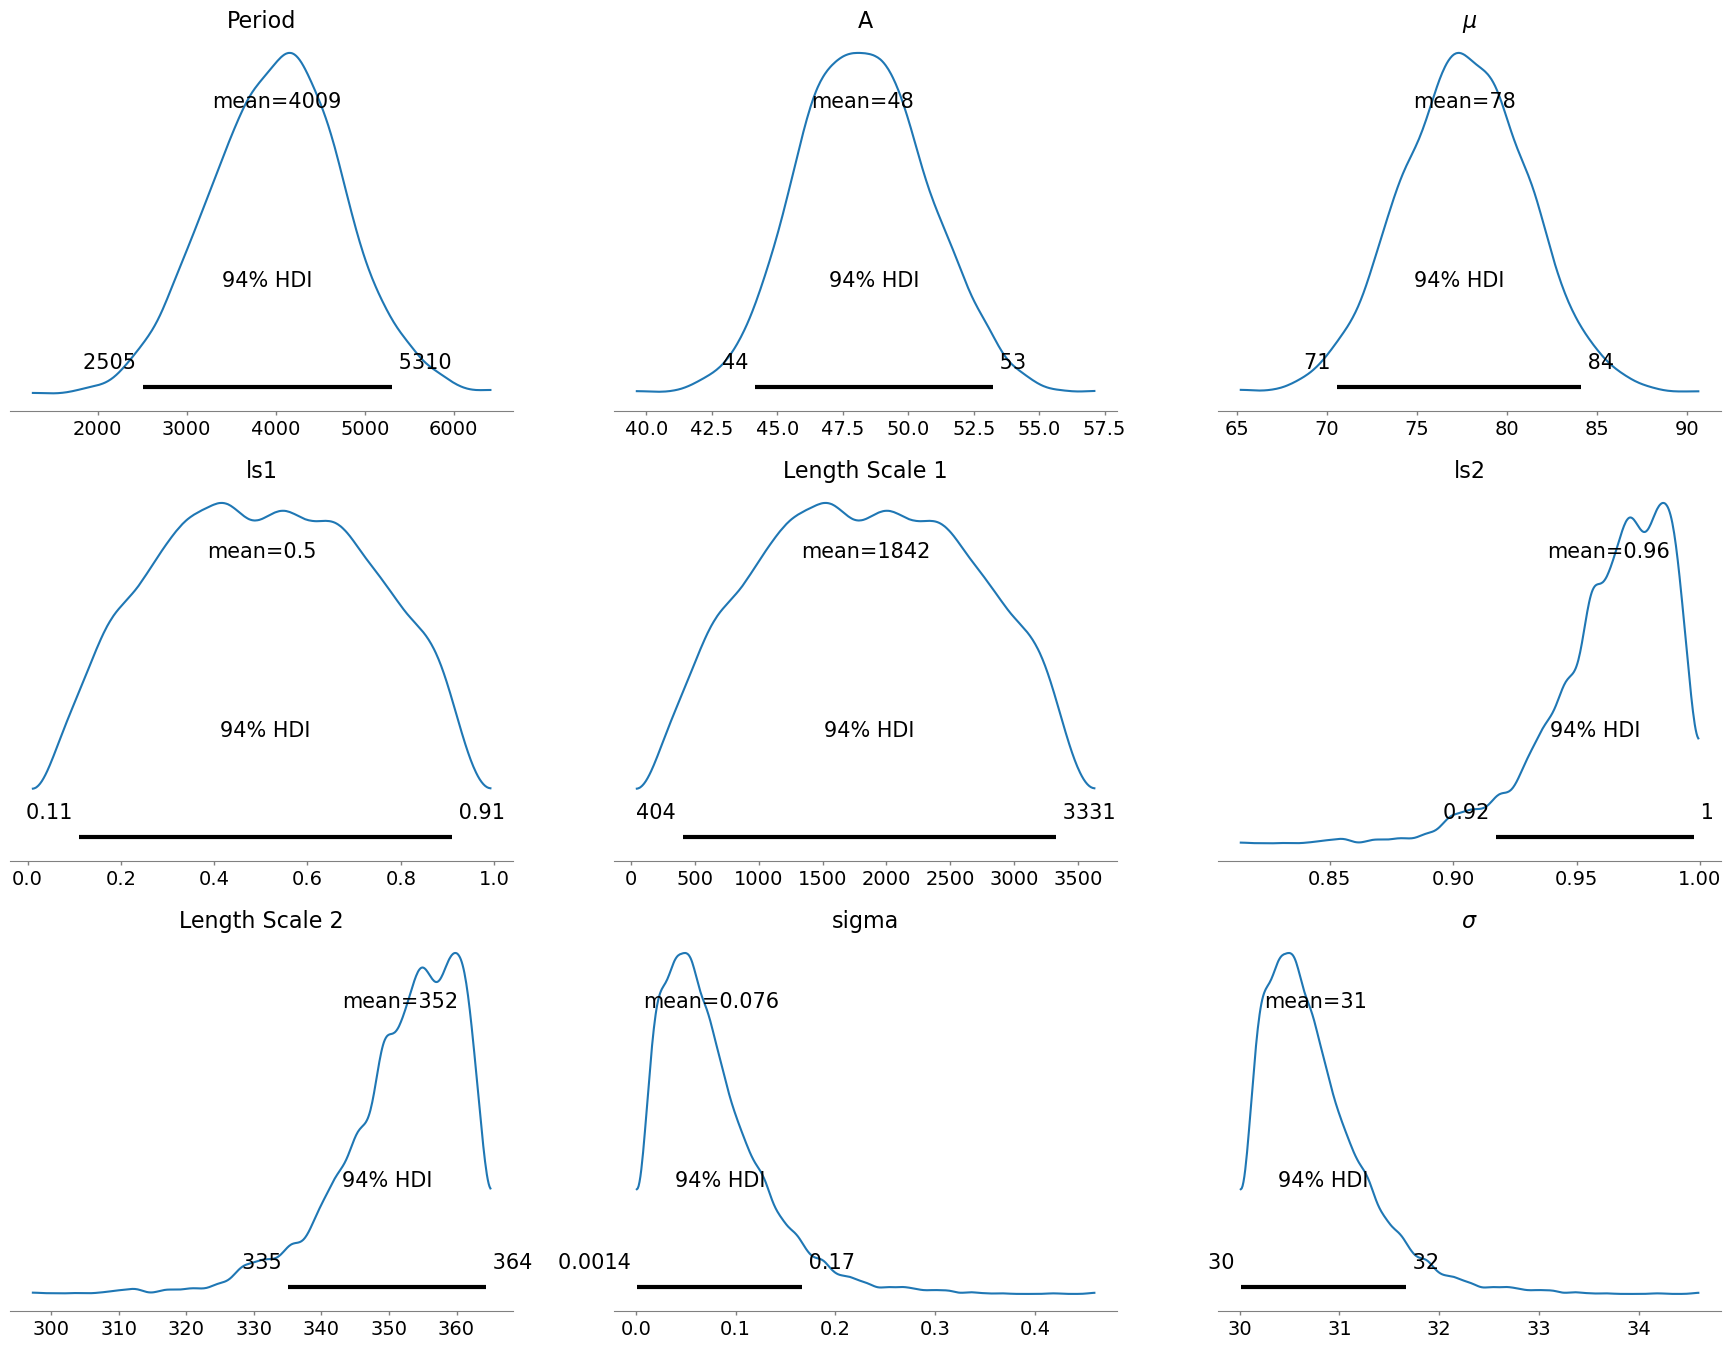

In [50]:
az.plot_posterior(tr);

In [62]:
X_new = np.linspace(min(time_train)[0]-0.02e6, max(time_train)[0]+0.02e6, 500)[:, None]
with model:
    fnew = gp.conditional("fnew", Xnew=X_new)

with model:
    ppc = pm.sample_posterior_predictive(tr, samples=100, var_names=["fnew"])#

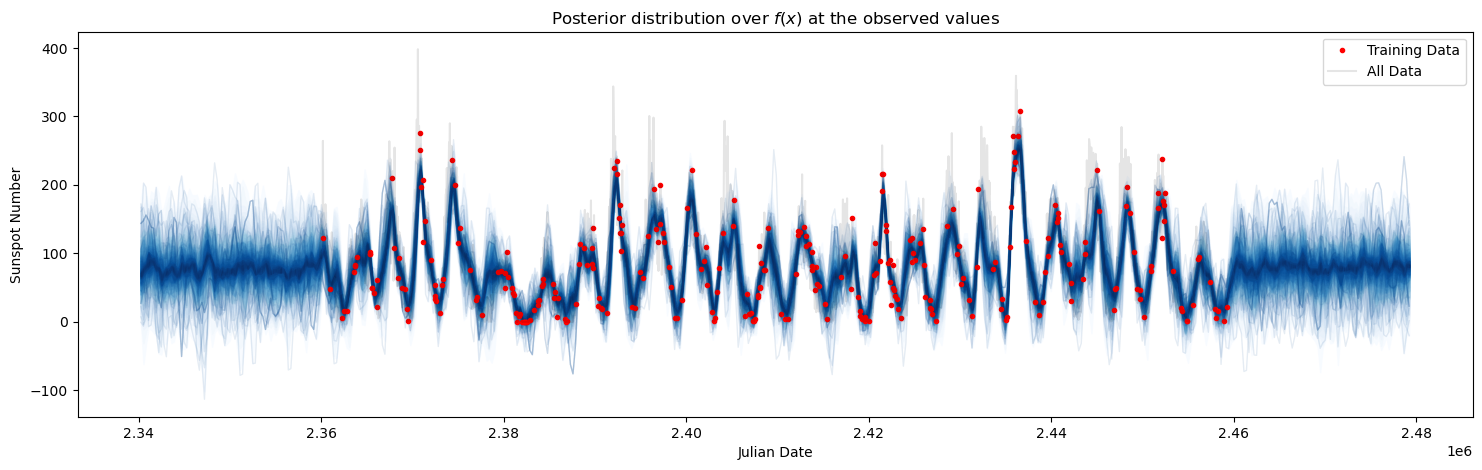

In [63]:
from pymc3.gp.util import plot_gp_dist

# draw plot
fig = plt.figure(figsize=(18, 5))
ax = fig.gca()
plot_gp_dist(ax, ppc['fnew'], X_new, palette="Blues")

# plot original data and true function
plt.plot(time_train, y_train, "or", ms=3, alpha=1.0, label="Training Data")
plt.plot(time, y, ms=1, alpha=0.1, color="black", label="All Data")

plt.xlabel("Julian Date")
plt.ylabel("Sunspot Number")
plt.title("Posterior distribution over $f(x)$ at the observed values")
plt.legend();

### Comment on plot:

Attempted to fit the mean monthly data with some success. Priors were chosen based on priors used for the SVG smoothed GPR. However, the key point here is that we still do not get any good prediction of past/future cycles

There has to be a trade off between accuracy of predicting the data and the predictive power (i.e. when the length scale is too long, the fitting becomes worse but it is able to predict further into the future).